In [6]:
import sys
import pandas as pd
import numpy as np

sys.path.append('..')

In [3]:
import rbf_functions

In [4]:
rbf = rbf_functions.gaussian_rbf.__name__
output_dir = f"../output/{rbf}/"

In [39]:
archives_by_nfe = pd.read_csv(output_dir + '10_hypervolume.csv')
print(f"rows: {archives_by_nfe['0'].count()}")

nfes = archives_by_nfe["Unnamed: 0"].values
u_nfes = np.unique(nfes)
selected_nfe = u_nfes[0::5]
archives_by_nfe = archives_by_nfe.loc[archives_by_nfe['Unnamed: 0'].isin(selected_nfe )]

print(f"Selected: {len(selected_nfe)} nfe generations:")
print(selected_nfe)
print(f"rows: {archives_by_nfe['0'].count()}")
archives_by_nfe.head()


rows: 31820
Selected: 30 nfe generations
[  100   600  1100  1600  2100  2600  3100  3600  4100  4600  5100  5600
  6100  6600  7100  7600  8100  8600  9100  9600 11519 15859 20199 24539
 28879 33219 37559 41899 46239 50579]
rows: 6596


,Unnamed: 0,Unnamed: 1,0,1,2,3,4,5
0,100,0,44.992592,0.550813,0.433861,0.318733,0.084848,1.0
1,100,1,45.509716,0.202915,0.163180,0.148392,0.081956,1.0
2,100,2,46.095984,0.295024,0.333018,0.155382,0.085453,1.0
3,100,3,30.257661,0.178661,0.167211,0.185919,0.081523,1.0
4,100,4,60.084563,0.545179,0.371366,0.321381,0.086085,1.0


we need to transform the dataframe back into platypus solution instances.

We need to have a collection of solutions for each generation


In [23]:
from platypus import Solution, Problem

n_rbfs = 4
n_objs = 6
n_vars = n_rbfs * 8 

problem = Problem(n_vars, n_objs)

# matters for hypervolume
problem.directions[0] = Problem.MAXIMIZE  # hydropower
problem.directions[1] = Problem.MAXIMIZE  # atomic power plant
problem.directions[2] = Problem.MAXIMIZE  # baltimore
problem.directions[3] = Problem.MAXIMIZE  # chester
problem.directions[4] = Problem.MAXIMIZE  # environment
problem.directions[5] = Problem.MAXIMIZE  # recreation

archives = {}
for nfe, generation in archives_by_nfe.groupby("Unnamed: 0"):
    # we slice from 2, getting rid of the first two columns 
    # which contain the NFE and ID of each solution
    archive = []
    for i, row in generation.iloc[:, 2::].iterrows():
        solution = Solution(problem)
        solution.objectives = row
        archive.append(solution)
    archives[nfe] = archive
        


in this case our reference set is the final set of solutions (only a single seed). So let's load this data as well and turn it into a set of solution in the same way as we did with the archives.

In [24]:
data = pd.read_csv(output_dir + '10_solution.csv')

ref_set = []
for i, row in data.iterrows():
    solution = Solution(problem)
    solution.objectives = row
    ref_set.append(solution)


In [25]:
data

,hydropower,atomicpowerplant,baltimore,chester,environment,recreation
0,25.810268,0.982939,0.660340,0.871282,0.252290,1.000000
1,32.128923,0.903763,0.866861,0.764369,0.356044,0.928571
2,27.513833,0.946178,0.819765,0.925183,0.315153,0.928571
3,29.695620,0.979989,0.777675,0.872959,0.231962,1.000000
4,34.213804,0.908574,0.869307,0.815410,0.353464,0.821429
...,...,...,...,...,...,...
287,7.789696,0.773208,0.866161,0.826991,0.453600,0.892857
288,56.184685,0.629452,0.883963,0.777227,0.154120,0.928571
289,23.992811,0.876045,0.868735,0.832453,0.411720,0.964286
290,54.202629,0.733276,0.382816,0.057053,0.212109,0.964286


In [26]:
from platypus import Hypervolume

hv = Hypervolume(reference_set=ref_set)

nfes = []
hvs = []
for nfe, archive in archives.items():
    nfes.append(nfe)
    hvs.append(hv.calculate(archive))

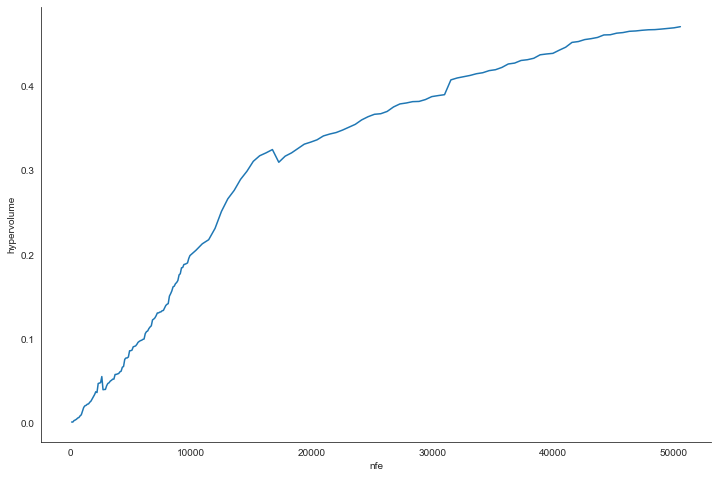

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("white")

fig, ax = plt.subplots()

ax.plot(nfes, hvs)
ax.set_xlabel('nfe')
ax.set_ylabel('hypervolume')

sns.despine()

plt.show()

In [28]:
e_progress = pd.read_csv(output_dir + '10_convergence.csv')
e_progress

,Unnamed: 0,nfe,improvements
0,0,100,35
1,1,200,50
2,2,300,71
3,3,400,88
4,4,500,106
...,...,...,...
171,171,48412,3243
172,172,48940,3256
173,173,49468,3268
174,174,49996,3279


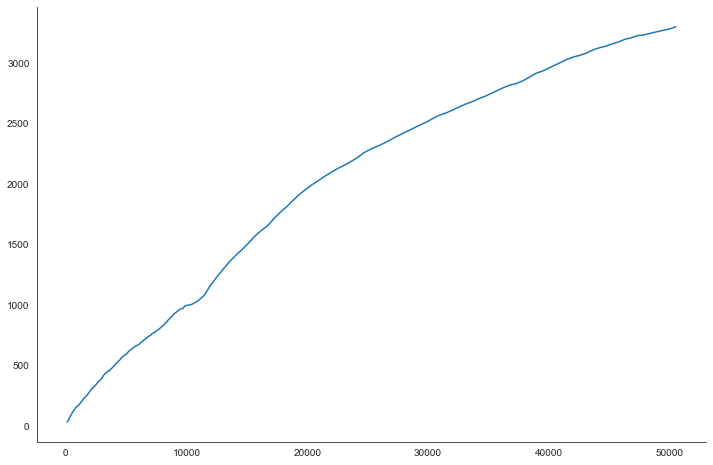

In [29]:
fig, ax = plt.subplots()
ax.plot(e_progress.nfe, e_progress.improvements)

sns.despine()

plt.show()